# Feature selection in high-dimensional genetic data

# Notebook 1: Classical GWAS

## Introduction

The goal of this practical session is to manipulate high-dimensional, low sample-size data that is typical of many genetic applications.

Here we will work with GWAS data from _Arabidopsis thaliana_, which is a plant model organism (https://upload.wikimedia.org/wikipedia/commons/6/6f/Arabidopsis_thaliana.jpg).

The genotypes are hence described by **Single Nucleotide Polymorphisms, or SNPs**. Our goal will be to use this data to identify regions of the genome that can be linked with various growth and flowering traits (**phenotypes**).

In [1]:
%pylab inline 
# imports matplotlib as plt and numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rc('font', **{'size': 14}) # font size for text on plots

## Data description

* `data/athaliana_small.X.txt` is the design matrix. As many rows as samples, as many columns as SNPs
* the SNPs are given (in order) in `data/athaliana_small.snps.txt`. 
* the samples are given (in order) in `data/athaliana.samples.txt`.

* the transformed phenotypes are given in `data/athaliana.4W.pheno` and `data/athaliana.2W.pheno`. The first column is the sample's ID, and the second the phenotype.

* `data/athaliana.candidates.txt` contains a list of _A. thaliana_ genes known or strongly suspected to be associated with flowering times.

* the feature network is in `data/athaliana_small.W.txt`. It has been saved as 3 arrays, corresponding to the row, col, and data attributes of a [scipy.sparse coo_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html).

## Loading the data
We will start by working without the feature network, on the 2W phenotype.

In [3]:
# Load the SNP names
with open('data/athaliana_small.snps.txt') as f:
    snp_names = f.readline().split()
    f.close()
print(len(snp_names))

9419


In [4]:
# Load the design matrix -- this can take time!
X = np.loadtxt('data/athaliana_small.X.txt',  # file names
               dtype = 'int') # values are integers

__Q: How many samples are there in the data? How many SNPs are there?__

In [5]:
# Answer
X.shape

(1307, 9419)

We have 1307 samples and 9 419 SNPs.

In [6]:
p = X.shape[1]

#### Loading the samples

In [7]:
samples = list(np.loadtxt('data/athaliana.samples.txt', # file names
                         dtype=int)) # values are integers
print(len(samples))

1307


#### Loading the 2W phenotype 

The 2W phenotype os the number of days for the required for the flower stalk to reach 5cm, when plants have been growing at 23°C, with 16hrs of daylight, and have been vernalized for 2 weeks at 5°C with 8hrs of daylight.

In [8]:
import pandas as pd

In [9]:
df_2W = pd.read_csv('data/athaliana.2W.pheno', # file name
                 header=None, # columns have no header
                 delim_whitespace=True, # columns are separated by white space
                 index_col=0) # read the first column as index

In [10]:
# Create vector of sample IDs
samples_with_phenotype_2W = list(df_2W.index)
print(len(samples_with_phenotype_2W), "samples have a 2W phenotype")

# Create vector of phenotypes
y_2W = df_2W[1].to_numpy()

152 samples have a 2W phenotype


The 2W phenotype is not available for all samples. We need to restrict X to the samples with a 2W phenotype, in correct order

In [12]:
X_2W = X[np.array([samples.index(sample_id) \
                   for sample_id in samples_with_phenotype_2W]), :]

__Q: How many samples do we have now? And how many SNPs? Does this make the task of biomarker detection simpler or harder?__

In [13]:
print(X_2W.shape)

(152, 9419)


__A:__ We have the same number of features but (way) fewer samples: the statistical power has decreased! And so the task of detecting explanatory SNPs is harder.

In [14]:
# You can delete X now to free space
del X

#### Loading the list of candidate genes

Candidate genes are genes that are known (or strongly suspected) to be associated with flowering traits in _A. thaliana_. They will serve as (imperfect) ground truth for our experiments.

In [15]:
with open('data/athaliana.candidates.txt') as f:
    candidate_genes = f.readline().split()
    f.close()

#### Loading the SNPs-to-gene mapping

Remember our features are Single-Nucleotide Polymorphisms. In order to compare selected SNPs to candidate genes, we need to map SNPs to genes in or near which they are located.

In [16]:
genes_by_snp = {} # key: SNP, value = [genes in/near which this SNP is]
with open('data/athaliana.snps_by_gene.txt') as f:
    for line in f:
        ls = line.split()
        gene_id = ls[0]
        for snp_id in ls[1:]:
            if not snp_id in genes_by_snp:
                genes_by_snp[snp_id] = []
            genes_by_snp[snp_id].append(gene_id) 

## Splitting the data into a train and test set

In machine learning, we always split the data into a *train* set, which serves to fit the model, and a *test* set, which serves to measure the model's performance.

__Q: Why? What happens if we do both the training and testing on the same data?__

__A:__ Evaluating a model on the same data used to fit the model favors model that overfit the data at hand, and these models have poor generalization performance.

We will set aside a test set, containing 20% of our samples, on which to evaluate the quality of our predictive models.

__Q: What problem occurs if we set a test set that is too large in proportion? What problem occurs when it is set too small?__

__A:__ If the proportion of samples in the test set is too large, the training set becomes too small to be able to fit the model correctly. If it is too small, the measure of performance of the model will be prone to too much variability.

In [17]:
from sklearn import model_selection

In [18]:
X_2W_tr, X_2W_te, y_2W_tr, y_2W_te = \
    model_selection.train_test_split(X_2W, y_2W, test_size=0.2, random_state=17)
print(X_2W_tr.shape, X_2W_te.shape)

(121, 9419) (31, 9419)


## Data exploration
### Visualizing the phenotype

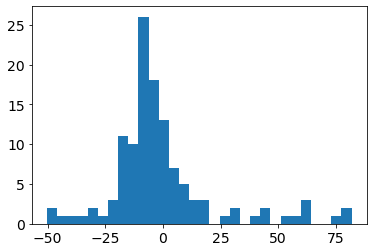

In [19]:
h = plt.hist(y_2W_tr, bins=30)

### Visualizing the genotype's correlation structure

In [20]:
#import seaborn as sn
sigma = pd.DataFrame(X_2W_tr).corr()

Text(0.5, 1.0, 'Correlation between the first 1000 SNPs')

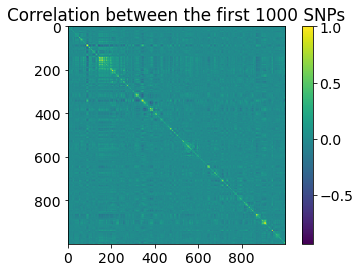

In [21]:
fig = plt.figure()
plt.imshow(sigma.iloc[0:1000, 0:1000])
plt.colorbar()
plt.title("Correlation between the first 1000 SNPs")

Text(0.5, 1.0, 'Correlation between the first 100 SNPs')

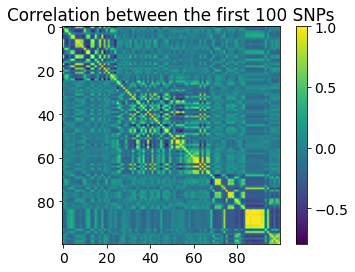

In [22]:
fig = plt.figure()
plt.imshow(sigma.iloc[0:100, 0:100])
plt.colorbar()
plt.title("Correlation between the first 100 SNPs")

__Q: What observation can you make about the phenotype and genotype?__

__A:__ The phenotype has an unimodal distribution (only one peak), but with a few outlying values.

The genotype has a correlation structure which displays "blocks" of high correlation, called *Linkage Disequilibrium* (LD) blocks.

## T-tests

Let us start by running a statistical test for association of each SNP feature with the phenotype.

In [23]:
import statsmodels.api as sm

### T-test on a single SNP
We will perform a linear regression on a single SNP and test whether this SNP has an effect on the phenotype.

In [24]:
est = sm.regression.linear_model.OLS(y_2W_tr, sm.add_constant(X_2W_tr[:, 0])).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.038
Date:                Thu, 15 Jul 2021   Prob (F-statistic):              0.310
Time:                        12:17:11   Log-Likelihood:                -552.37
No. Observations:                 121   AIC:                             1109.
Df Residuals:                     119   BIC:                             1114.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8295      2.588     -0.707      0.4

__Q: In the previous table, where is the p-value of the T-test? What can you conclude about the effect of the first SNP on the phenotype?__

__A:__ The p-value is 0.310: we cannot reject $\mathcal{H}_0$, and so the first SNP is estimated to have no effect on the phenotype.

### T-test on all SNPs

In [25]:
pvalues = []
for snp_idx in range(p):
    # only look a the column corresponding at that SNP
    X_snp = X_2W_tr[:, snp_idx]
    # run a linear regression (with bias) between the phenotype and this SNP
    X_snp = sm.add_constant(X_snp)
    est = sm.regression.linear_model.OLS(y_2W_tr, X_snp)
    est2 = est.fit()
    # get the p-value from the model 
    pvalues.append(est2.pvalues[1])
pvalues = np.array(pvalues)

### Manhattan plot

The common way to visualize such results is by using a Manhattan plot: we will plot all SNPs on the x-axis, and on the y-axis we'll have the opposite of the log base 10 of the p-value. The lower the p-value, the higher the corresponding marker. 

We will also add a horizontal line that corresponds to the _threshold for significance_. Because we are testing multiple hypotheses, we need to lower our threshold accordingly. We will use __Bonferroni correction__ and divide the significance threshold (say, alpha=0.05) by the number of tests, that is, the number of SNPs p.

(0.0, 9419.0)

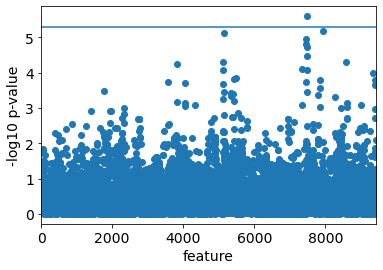

In [26]:
plt.scatter(range(p), # x = SNP position
            -np.log10(pvalues)) # y = -log10 p-value 

# significance threshold according to Bonferroni correction
t = -np.log10(0.05 / p)
plt.plot([0, p], [t, t])

# plot labels
plt.xlabel("feature")
plt.ylabel("-log10 p-value")
plt.xlim([0, p])

__Q: What do you observe? Are any SNPs significantly associated with the phenotype? 
Use data/athaliana.snps_by_gene.txt and data/athaliana.candidates.txt to check whether this matches a priori information.__

In [27]:
# Answer

thresh = 0.05 / p # significance threshold set using the Bonferroni correction

for snp_idx in np.where(pvalues < thresh)[0]:
    print(("%.2e" % pvalues[snp_idx]), snp_names[snp_idx])
    for gene_id in genes_by_snp[snp_names[snp_idx]]:
        if gene_id in candidate_genes:
            print("\t in/near candidate gene %s" % gene_id)

2.56e-06 Chr5_3185806_C
	 in/near candidate gene AT5G10140


__A:__ Chr5_3185806_C is just at significance threshold with a p-value of 2x10^-6. It is in or near gene [AT5G10140](https://www.arabidopsis.org/servlets/TairObject?accession=locus:2184118), which is known to play a role in flowering.